# Predicting Housing Prices in Ames, IA (using Regression)

In [5]:
# Import key library functions needed.
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import r2_score 
from sklearn.metrics import explained_variance_score
#from error_metrics import *
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import RFECV
from sklearn.metrics import r2_score
from sklearn.metrics import make_scorer

# Load the data.
housing = pd.read_csv('AmesHousingSetA.csv')
housing.head()

,PID,MS.SubClass,MS.Zoning,Lot.Frontage,Lot.Area,Street,Alley,Lot.Shape,Land.Contour,Utilities,...,Pool.Area,Pool.QC,Fence,Misc.Feature,Misc.Val,Mo.Sold,Yr.Sold,Sale.Type,Sale.Condition,SalePrice
0,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
1,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
2,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
3,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900
4,527105030,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2010,WD,Normal,195500


In [6]:
# Get a list of the categorical features for a given dataframe. Move to util file for future use!
def cat_features(dataframe):
    td = pd.DataFrame({'a':[1,2,3],'b':[1.0,2.0,3.0]})
    return filter(lambda x: not(dataframe[x].dtype in [td['a'].dtype, td['b'].dtype]), list(dataframe))

In [7]:
# Transform data
# Drop the PID column, since it does not make sense as a predictor.
del housing['PID']

# Replace NaN values with mean of column.
housing = housing.fillna(housing.mean())

for i in list(cat_features(housing)):
    housing[i] = housing[i].fillna('none')
    
# Perform one-hot encoding on the data.
housing = pd.get_dummies(housing, columns=list(cat_features(housing)))
housing.head()

,MS.SubClass,Lot.Frontage,Lot.Area,Overall.Qual,Overall.Cond,Year.Built,Year.Remod.Add,Mas.Vnr.Area,BsmtFin.SF.1,BsmtFin.SF.2,...,Sale.Type_ConLw,Sale.Type_New,Sale.Type_Oth,Sale.Type_WD,Sale.Condition_Abnorml,Sale.Condition_AdjLand,Sale.Condition_Alloca,Sale.Condition_Family,Sale.Condition_Normal,Sale.Condition_Partial
0,20,80.0,11622,5,6,1961,1961,0.0,468.0,144.0,...,0,0,0,1,0,0,0,0,1,0
1,20,81.0,14267,6,6,1958,1958,108.0,923.0,0.0,...,0,0,0,1,0,0,0,0,1,0
2,20,93.0,11160,7,5,1968,1968,0.0,1065.0,0.0,...,0,0,0,1,0,0,0,0,1,0
3,60,74.0,13830,5,5,1997,1998,0.0,791.0,0.0,...,0,0,0,1,0,0,0,0,1,0
4,60,78.0,9978,6,6,1998,1998,20.0,602.0,0.0,...,0,0,0,1,0,0,0,0,1,0


## I. Data Preparation Questions
### What specific data transforms did you perform prior to exploration and analysis, and why did you choose these?
I chose to drop the PID column because it is an identification number and did not make sense as a predictor. Then I one-hot encoded the categorical columns so that I could use them in my regression model. There was a lot of NaN values so I replaced them with the mean value of the column that they belong to. I had to get rid of the NaN values to be able to do regression. I replaced them with the mean values in hopes that it would not have much of an upward or downward pull on the model.


## II. Exploratory Analysis Questions
#### What (if any) insights jump out at you? Do you have any hypotheses about relationship of certain variables to the price?
I expect that the lot frontage, lot area, and bedrooms columns will have a strong relationship with the overall price of the house. 

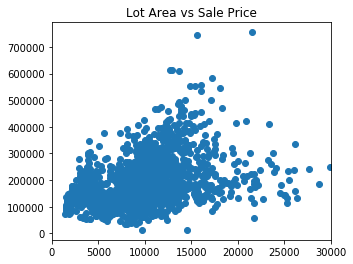

In [166]:
#Plot data.
plt.scatter(housing['Lot.Area'], housing['SalePrice'])
plt.xlim(0,30000)
plt.title('Lot Area vs Sale Price')

fig_size[0] = 5
fig_size[1] = 4
plt.rcParams["figure.figsize"] = fig_size
plt.show()

In [284]:
# Get information about data. 
housing.describe()

,MS.SubClass,Lot.Frontage,Lot.Area,Overall.Qual,Overall.Cond,Year.Built,Year.Remod.Add,Mas.Vnr.Area,BsmtFin.SF.1,BsmtFin.SF.2,...,Sale.Type_ConLw,Sale.Type_New,Sale.Type_Oth,Sale.Type_WD,Sale.Condition_Abnorml,Sale.Condition_AdjLand,Sale.Condition_Alloca,Sale.Condition_Family,Sale.Condition_Normal,Sale.Condition_Partial
count,2344.000000,2344.000000,2344.000000,2344.000000,2344.000000,2344.000000,2344.000000,2344.000000,2344.000000,2344.000000,...,2344.00000,2344.000000,2344.00000,2344.000000,2344.000000,2344.000000,2344.000000,2344.000000,2344.000000,2344.000000
mean,57.107509,69.206064,10060.029437,6.088311,5.596416,1970.867747,1984.387799,102.155565,442.388818,50.454119,...,0.00256,0.081485,0.00256,0.867321,0.069113,0.004266,0.008532,0.014932,0.819539,0.083618
std,42.679857,21.619141,6577.642538,1.414624,1.117931,30.407146,20.914644,182.157813,461.087509,168.774985,...,0.05054,0.273636,0.05054,0.339300,0.253700,0.065191,0.091996,0.121306,0.384653,0.276873
min,20.000000,21.000000,1470.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,20.000000,60.000000,7444.500000,5.000000,5.000000,1953.000000,1965.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.00000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,50.000000,69.206064,9436.500000,6.000000,5.000000,1972.000000,1993.000000,0.000000,370.000000,0.000000,...,0.00000,0.000000,0.00000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,70.000000,78.000000,11604.000000,7.000000,6.000000,2000.000000,2004.000000,161.000000,732.000000,0.000000,...,0.00000,0.000000,0.00000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,190.000000,313.000000,164660.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1526.000000,...,1.00000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## III. Model Building (using set A ONLY!!)

In [8]:
# Get x/y data and split into training/test sets.
data_x = housing.loc[:, housing.columns != 'SalePrice']
data_y = housing['SalePrice']
x_train, x_test, y_train, y_test = train_test_split(data_x, data_y, test_size = 0.2)

In [11]:
# Build the Baseline Model. 
base_model = linear_model.LinearRegression()
base_model.fit(x_train, y_train) #Fit the model
preds = base_model.predict(x_test) #Build predictions on the test data
print('R^2 score: ',r2_score(y_test, preds))

R^2 score:  0.8983937987326133


In [12]:
# Try f-selection (top 25%)
selector_f = SelectPercentile(f_regression, percentile=25)
selector_f.fit(x_train, y_train)
#for name, score, pv in zip(list(housing), selector_f.scores_, selector_f.pvalues_):
    #print('F-score, p-value, ('+ name + '): '+ str(score)+ ', '+ str(pv))

/anaconda3/lib/python3.7/site-packages/sklearn/feature_selection/univariate_selection.py:299: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


SelectPercentile(percentile=25,
         score_func=<function f_regression at 0x1a1efb2e18>)

In [13]:
# Get the feature-selected data
xt_train, xt_test = selector_f.transform(x_train), selector_f.transform(x_test)

# Build and test the new model with the selected features
f_model = linear_model.LinearRegression()
f_model.fit(xt_train, y_train)
preds = f_model.predict(xt_test)
print('R^2 score: ',r2_score(y_test, preds))

R^2 score:  0.8884824313436429


In [14]:
# Try f-selection (top 30 features)
# Create a feature selector to get the top 3 features by the F metric
selector_f2 = SelectKBest(f_regression, k=30)

# Get the feature-selected data
xt2_train, xt2_test = selector_f2.fit_transform(x_train, y_train), selector_f2.transform(x_test)

# Build and test the new model with the selected features
f2_model = linear_model.LinearRegression()
f2_model.fit(xt2_train, y_train)
preds = f2_model.predict(xt2_test)
print('R^2 score: ',r2_score(y_test, preds))

R^2 score:  0.8873036050281636


/anaconda3/lib/python3.7/site-packages/sklearn/feature_selection/univariate_selection.py:299: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


In [16]:
# Try Lasso Regression
#alphas = [8.15, 8.2, 8.25]

lasso_model = linear_model.Lasso(alpha=8.25, normalize=True, fit_intercept=True)
lasso_model.fit(x_train, y_train)
preds = lasso_model.predict(x_test)
print('R^2 score: ', (r2_score(y_test, preds)))
    
# Best R^2 value with alpha set at 8.25

R^2 score:  0.9169005892243103


### Model Building Questions
#### What approach did you use to arrive at the best model? Why did you select this approach? Which error metric(s) are you using to compare performance? What is the value(s) of the error metric(s) for the baseline model and your best model?
I tried f-selection using the top percentile of features, f-selection using the top k features, and lasso regression. I compared the R^2 values to the baseline model and found the lasso regression made the biggest improvements. I looped through many different alpha values to find that alpha=8.25 got the best R^2 value. I focused on the R^2 values because it is the most readable for humans. The R^2 value for my baseline model is 0.8791943201086281 while the R^2 value for my best model is 0.9169005892243103.

## Predicting and Validating (using set B)

In [18]:
# Load the data.
setB = pd.read_csv('AmesHousingSetB.csv')
setB.head()

,PID,MS.SubClass,MS.Zoning,Lot.Frontage,Lot.Area,Street,Alley,Lot.Shape,Land.Contour,Utilities,...,Pool.Area,Pool.QC,Fence,Misc.Feature,Misc.Val,Mo.Sold,Yr.Sold,Sale.Type,Sale.Condition,SalePrice
0,528348030,60,RL,83.0,10790,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,252000
1,528108010,20,RL,110.0,14230,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,7,2009,WD,Normal,256300
2,535179060,20,RL,80.0,11900,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2008,WD,Normal,166000
3,908201110,90,RL,65.0,6012,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2008,WD,AdjLand,82000
4,528142140,60,RL,85.0,10574,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,7,2008,WD,Normal,316000


In [19]:
# Transform data
del setB['PID']

setB = setB.fillna(setB.mean())

for i in list(cat_features(setB)):
    setB[i] = setB[i].fillna('none')
    
# Perform one-hot encoding on the data.
setB = pd.get_dummies(setB, columns=list(cat_features(setB)))
setB.head()

,MS.SubClass,Lot.Frontage,Lot.Area,Overall.Qual,Overall.Cond,Year.Built,Year.Remod.Add,Mas.Vnr.Area,BsmtFin.SF.1,BsmtFin.SF.2,...,Sale.Type_New,Sale.Type_Oth,Sale.Type_VWD,Sale.Type_WD,Sale.Condition_Abnorml,Sale.Condition_AdjLand,Sale.Condition_Alloca,Sale.Condition_Family,Sale.Condition_Normal,Sale.Condition_Partial
0,60,83.0,10790,7,5,1998,1998,275.0,0,0,...,0,0,0,1,0,0,0,0,1,0
1,20,110.0,14230,8,5,2007,2007,640.0,0,0,...,0,0,0,1,0,0,0,0,1,0
2,20,80.0,11900,6,5,1957,1957,387.0,1040,0,...,0,0,0,1,0,0,0,0,1,0
3,90,65.0,6012,4,5,1955,1955,0.0,0,0,...,0,0,0,1,0,1,0,0,0,0
4,60,85.0,10574,8,5,2004,2004,126.0,856,0,...,0,0,0,1,0,0,0,0,1,0


In [20]:
# Get features and target (x and y)
x = setB.loc[:, setB.columns != 'SalePrice']
y = setB['SalePrice']

In [294]:
# Baseline Model
base_preds = base_model.predict(x)
print('Baseline Model R^2: '+str(r2_score(y, base_preds)))

# Best Model
lasso_preds = lasso_model.predict(x)
print('Lasso Model R^2: '+str(r2_score(y, lasso_preds)))

ValueError: shapes (586,285) and (313,) not aligned: 285 (dim 1) != 313 (dim 0)

### What are the respective error metric values for each model on this set? How did your best model do on this data as compared to the baseline? Is your best model a good model? Why or why not?
